EDA --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)  
RF/XGB/LGBM & model explaination --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-rf-xgb-lgbm-model-explaination-s4e3)  
Origin vs. Train datasets, effect of adding original dataset on model score --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-effect-of-adding-original-data-s4e3)  
Data balancing effect --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-data-balance-effect-s4e3)

### Objective

- Inspired by [Oscar Aguilar's discussion](https://www.kaggle.com/competitions/playground-series-s4e3/discussion/482401), I'd like to study the effect of dropping unimportant features for different models, and what is the best criteria to select unimportant features.

In [53]:
# setup environment
input_path = './data/'
output_path = './output05/'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [6]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset
df_origin_raw = pd.read_csv(input_path + 'Steel Plates Faults.csv') # original dataset

predict_features = df_train_raw.columns.to_list()[-7:]

# X transformer function
def X_transformer(X_raw):
    X = X_raw.copy()
    X['X_Center'] = (X['X_Maximum'] + X['X_Minimum'])/2
    X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
    X['Y_Center'] = (X['Y_Maximum'] + X['Y_Minimum'])/2
    X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']
    X['Aspect_Ratio'] = X['Y_Perimeter'] / X['X_Perimeter']
    X['Mean_Luminosity'] = X['Sum_of_Luminosity'] / X['Pixels_Areas']
    X['Delta_Luminosity'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
    X['Log_Pixel_Resolution'] = ((10**X['LogOfAreas']) / X['Pixels_Areas']).apply(np.log10)
    if 'id' in X.columns:
        X.drop(columns=['id'], inplace=True)
    return X

df_origin = X_transformer(df_origin_raw)
df_train_full = X_transformer(df_train_raw)
df_test = X_transformer(df_test_raw)

# split train, val datasets
stratify = np.zeros(df_train_full.shape[0])
for defect in predict_features:
    stratify = 10*stratify + df_train_full[defect]
## combine dual labelled groups to avoid split error (only 1 row in a group)
stratify = stratify.apply(lambda x: 10001 if x in [10010, 1010000] else x)
## split
df_train, df_val = train_test_split(df_train_full, test_size=0.25,
                                    stratify=stratify, random_state=42)
X_val = df_val.drop(columns=predict_features)
Y_val = df_val[predict_features]

X_train = df_train.drop(columns=predict_features)
Y_train = df_train[predict_features]

In [7]:
# permutation importance using all features
permu_importance = {'feature': X_train.columns.to_list()}
for defect in predict_features:
    model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
    model.fit(X_train, Y_train[defect])
    permu_importance[defect] = permutation_importance(model, X_val, Y_val[defect], scoring='roc_auc', n_repeats=50,
                                                       n_jobs=-1, random_state=0)['importances_mean']
permu_importance = pd.DataFrame(permu_importance).set_index('feature')


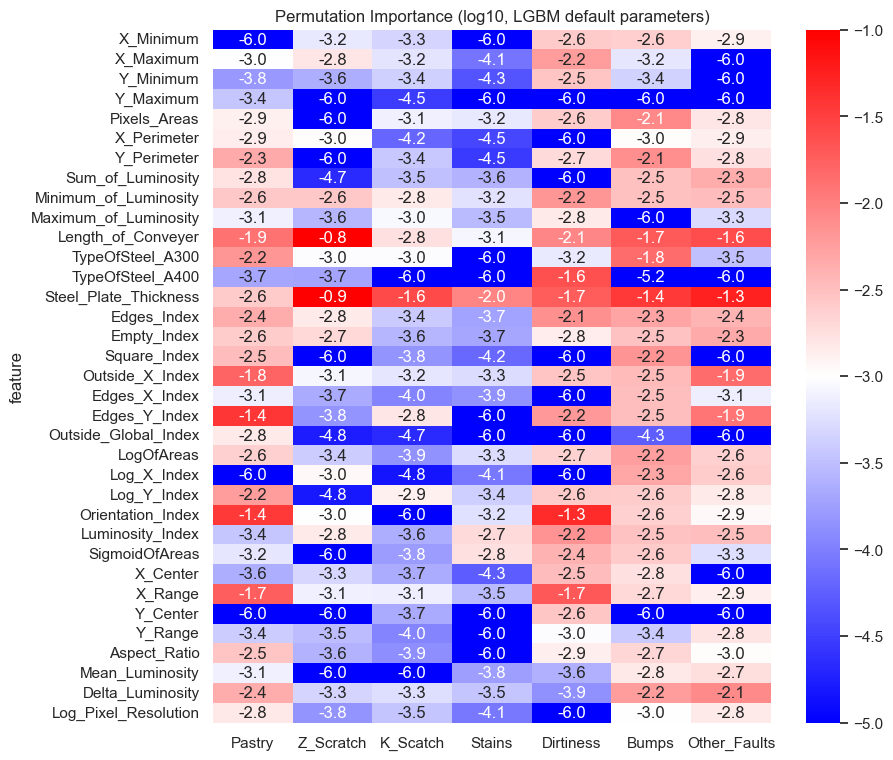

In [61]:
# plot permu_importance
df_temp = permu_importance.copy()
for index in df_temp.index:
    for col in df_temp.columns:
        df_temp.loc[index, col] = max(df_temp.loc[index, col], 1e-6)

fig = plt.figure(figsize=(9, 9))
sns.heatmap(np.log10(df_temp), annot=True, fmt='.1f', cmap='bwr', vmax=-1, vmin=-5)
plt.title('Permutation Importance (log10, LGBM default parameters)')
plt.show()

**Experiment plan**  
- Compare LGBM and XGB models, both using default parameter setting.
- Compare different criteria (on permutation importance) to select features

In [20]:
# LGBM model result
summary_lgbm = {'threshold': [-np.inf, 1e-6, 1e-5, 1e-4, 1e-3]}
for defect in predict_features:
    summary_lgbm[defect] = []
    for threshold in summary_lgbm['threshold']:
        # features with permu_importance higher than threshold
        features = X_train.columns.to_list()
        for feature in X_train.columns:
            if permu_importance.loc[feature, defect] <= threshold:
                features.remove(feature)
        # fit model
        model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
        model.fit(X_train[features], Y_train[defect])
        y_score = model.predict_proba(X_val[features])[:, 1]
        auc_score = metrics.roc_auc_score(Y_val[defect], y_score)
        summary_lgbm[defect].append(auc_score)
df_summary_lgbm = pd.DataFrame(summary_lgbm)
df_summary_lgbm['Average_score'] = df_summary_lgbm[predict_features].mean(axis=1)
print('LGBM model:')
df_summary_lgbm

LGBM model:


,threshold,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Average_score
0,-inf,0.851802,0.962492,0.987192,0.993767,0.862241,0.807706,0.706594,0.881685
1,0.000001,0.851632,0.964305,0.986898,0.993698,0.863929,0.805993,0.706792,0.881892
2,0.000010,0.851632,0.964305,0.986898,0.993698,0.863929,0.805670,0.706792,0.881846
3,0.000100,0.851632,0.963272,0.987403,0.994216,0.863929,0.807153,0.706792,0.882057
4,0.001000,0.855503,0.962887,0.984722,0.991445,0.860782,0.806633,0.707719,0.881384


In [21]:
# XGB model result
summary_xgb = {'threshold': [-np.inf, 1e-6, 1e-5, 1e-4, 1e-3]}
for defect in predict_features:
    summary_xgb[defect] = []
    for threshold in summary_xgb['threshold']:
        # features with permu_importance higher than threshold
        features = X_train.columns.to_list()
        for feature in X_train.columns:
            if permu_importance.loc[feature, defect] <= threshold:
                features.remove(feature)
        # fit model
        model = XGBClassifier(n_jobs=-1, random_state=314)
        model.fit(X_train[features], Y_train[defect])
        y_score = model.predict_proba(X_val[features])[:, 1]
        auc_score = metrics.roc_auc_score(Y_val[defect], y_score)
        summary_xgb[defect].append(auc_score)
df_summary_xgb = pd.DataFrame(summary_xgb)
df_summary_xgb['Average_score'] = df_summary_xgb[predict_features].mean(axis=1)
print('XGBoost model:')
df_summary_xgb

XGBoost model:


,threshold,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Average_score
0,-inf,0.842118,0.958885,0.986168,0.993172,0.845461,0.787158,0.684695,0.871094
1,0.000001,0.841257,0.959348,0.985673,0.993495,0.865639,0.784585,0.680195,0.872885
2,0.000010,0.841257,0.959348,0.985673,0.993495,0.865639,0.784585,0.680195,0.872885
3,0.000100,0.841257,0.958478,0.986094,0.994090,0.865639,0.784585,0.680195,0.872905
4,0.001000,0.840801,0.959430,0.983381,0.990928,0.861059,0.791775,0.677627,0.872143


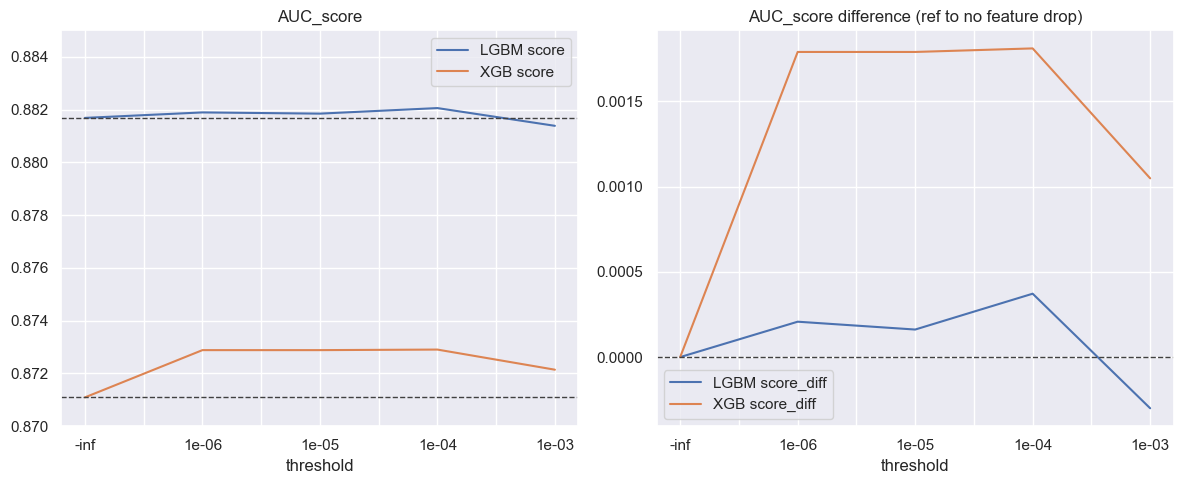

In [52]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_summary1 = pd.DataFrame()
df_summary1['threshold'] = df_summary_lgbm['threshold'].apply(lambda x: '{:.0e}'.format(x))
df_summary1['LGBM score'] = df_summary_lgbm['Average_score']
df_summary1['XGB score'] = df_summary_xgb['Average_score']
df_summary1.set_index('threshold').plot.line(ax=axs[0])
axs[0].set_ylim(0.87, 0.885)
axs[0].set_title('AUC_score')
axs[0].axhline(df_summary1.loc[0, 'LGBM score'], color='0.25', linewidth=1, ls='--')
axs[0].axhline(df_summary1.loc[0, 'XGB score'], color='0.25', linewidth=1, ls='--')

df_summary2 = pd.DataFrame()
df_summary2['threshold'] = df_summary_lgbm['threshold'].apply(lambda x: '{:.0e}'.format(x))
df_summary2['LGBM score_diff'] = df_summary_lgbm['Average_score'] - df_summary_lgbm.loc[0, 'Average_score']
df_summary2['XGB score_diff'] = df_summary_xgb['Average_score'] - df_summary_xgb.loc[0, 'Average_score']
df_summary2.set_index('threshold').plot.line(ax=axs[1])
axs[1].axhline(0, color='.25', linewidth=1, ls='--')
axs[1].set_title('AUC_score difference (ref to no feature drop)')

fig.tight_layout()
fig.show()

- Dropping unimportant features ***helps*** both `LGBM` and `XGB` models.
- Best criteria is **1e-4** for both models.
- Compare `LGBM' to `XGB` (both with default parameters)
    - Higher absolute auc score.
    - Less impact by feature selection.
    - Overall `LGBM` performance is better than `XGB`.

In [60]:
# submit file
df_submit = df_test_raw[['id']]
for defect in predict_features:
    threshold = 1e-4
    # features with permu_importance higher than threshold
    features = X_train.columns.to_list()
    for feature in X_train.columns:
        if permu_importance.loc[feature, defect] <= threshold:
            features.remove(feature)
    # fit model
    model = LGBMClassifier(**{'n_estimators': 716,
                            'learning_rate': 0.008655141501794094,
                            'max_depth': 5,
                            'reg_alpha': 0.9522134628349151,
                            'reg_lambda': 0.07875944420059292,
                            'num_leaves': 18,
                            'subsample': 0.33327260735952596,
                            'colsample_bytree': 0.45916663480321157, 
                            'verbose': -1})
    model.fit(df_train_full[features], df_train_full[defect])
    df_submit[defect] = model.predict_proba(df_test[features])[:, 1]
df_submit.to_csv(output_path+'submit.csv', index=False)